## Import libraries

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf

## Stock data to import: NVDA, AAPL, TSM, MSFT, NFLX

In [2]:
portfolio = ['NVDA', 'AAPL', 'TSM', 'MSFT', 'NFLX']

In [3]:
def load_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    df = df['Close']
    returns = df.pct_change()
    mean_return = returns.mean()
    volatility = returns.std()
    covariance_matrix = returns.cov()
    return mean_return, volatility, covariance_matrix

In [6]:
stocks = [stock for stock in portfolio]
start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime.now()
mean_return, volatilities, cov_matrix = load_data(stocks, start_date, end_date)

[*********************100%***********************]  5 of 5 completed


## Random Sample Portfolio Weights

In [ ]:
weights = np.random.random(len(mean_return))
weights /= np.sum(weights) # Normalize weights to sum to 1

In [8]:
print(weights)

[0.26655021 0.31110496 0.14352428 0.12085515 0.1579654 ]


## Monte Carlo Sim

In [38]:
number_of_simulations = 75
time_window = 90

In [39]:
mean = np.full((time_window, len(stocks)), fill_value=mean_return).T
portfolio_simulations = np.full(shape=(time_window, number_of_simulations), fill_value=0.0) # fill floats

In [40]:
capital = 100000

In [41]:
for m in range(number_of_simulations):
    Z = np.random.normal(size=(time_window, len(stocks)))
    L = np.linalg.cholesky(cov_matrix)
    correlated_randomness = L @ Z.T # inner product
    daily_returns = mean + correlated_randomness
    price_paths = np.exp(np.cumsum(daily_returns, axis=1))
    portfolio_price = capital * np.dot(weights, price_paths)
    portfolio_simulations[:, m] = portfolio_price

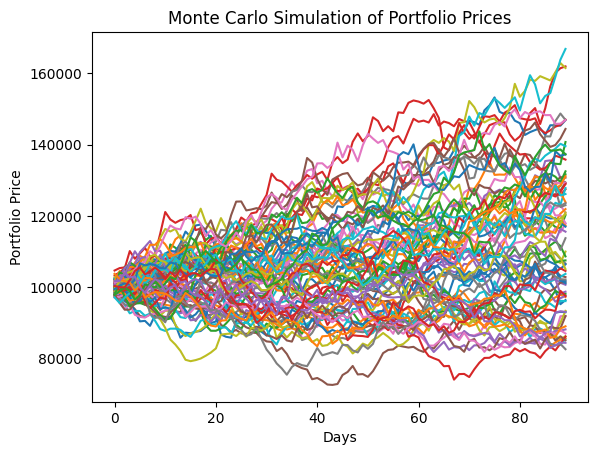

In [42]:
plt.plot(portfolio_simulations)
plt.xlabel('Days')
plt.ylabel('Portfolio Price')
plt.title('Monte Carlo Simulation of Portfolio Prices')
plt.show()

## Value at Risk

In [52]:
def VaR(returns, confidence_level=5):
    if isinstance(returns, pd.Series):
        return np.percentile(returns, confidence_level)
    elif isinstance(returns, pd.DataFrame):
        raise TypeError("DataFrame input not supported")

## Conditional Value at Risk

In [51]:
def CVaR(returns, confidence_level=5):
    if isinstance(returns, pd.Series):
        var = VaR(returns, confidence_level=confidence_level)
        return returns[returns <= var].mean()
    elif isinstance(returns, pd.DataFrame):
        raise TypeError("DataFrame input not supported")

In [53]:
portoflio_results = pd.Series(portfolio_simulations[-1, :])

In [54]:
VaR_95 = capital - VaR(portoflio_results, confidence_level=5) #95% Confidnce Level
CVaR_95 = capital - CVaR(portoflio_results, confidence_level=5)

In [56]:
print(f"Value at Risk (95% confidence): ${VaR_95:,.2f}")
print(f"Conditional Value at Risk (95% confidence): ${CVaR_95:,.2f}")

Value at Risk (95% confidence): $14,379.40
Conditional Value at Risk (95% confidence): $15,609.43
